# Analysis of Results

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

In [2]:
# define constants and paths
STANDARD_STEPS = S = 18265
ORIGINAL_VOCAB_SIZE = 16384

# paths
CACHE_DIR = "cache"
PLOT_DIR = "plots"
for d in [CACHE_DIR, PLOT_DIR]:
    os.makedirs(d, exist_ok=True)
ROOT_DIR = "."
FINETUNE_RESULTS_DIR = f"{ROOT_DIR}/finetune_results"
W2V_RESULTS_DIR = f"{ROOT_DIR}/w2v_results"


WANDB_PROJECT_PATH = "anton-thesis/duplication" # ADD YOUR WANDB PROJECT PATH HERE
def run_id2path(run_id):
    # ADD YOUR WANDB PROJECT PATH HERE
    return f"{WANDB_PROJECT_PATH}/{run_id}"

In [3]:
# load metrics
df_runs = pd.read_csv('runs.csv', index_col=0)
display(df_runs)

,model_size,train_steps,seed,frac_duplicated,p_dup,dedup_type,embed_noncanonical,ppl,ppl_dedup_all,ppl_dedup_lower,ppl_dedup_plural,ppl_dedup_whitespace
run_id,,,,,,,,,,,,
gj72vya7,medium,913,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
o4150u1i,medium,2190,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
ayixx7cf,medium,4566,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
h3fgcxe3,medium,9132,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
4iyoblte,medium,18621,0,0.0,NaN,NaN,False,16.668696,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
rd4zb4p4,tiny,913,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
8fix01b4,tiny,1826,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
o82oorgt,tiny,4566,0,0.0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


In [4]:
# setup plotting

import matplotlib

# Enable LaTeX rendering in the font of the paper
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
latex_path = "/Library/TeX/texbin/"
os.environ["PATH"] += os.pathsep + latex_path
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
"""

# set figure size defaults
PLOT_WIDTH = 3.5
PLOT_HEIGHT = 0.75 * PLOT_WIDTH
PLOT_WIDTH_FULL = 8
COL_C = "#085c84"
COL_W = "#c00444"
PW = "$\\hat{p} (\\boldsymbol{w})$"
PC = "$\\hat{p} (\\boldsymbol{c})$"
PPLS = "$\\mathrm{PPL}_\\mathbb{S}$"

def save_plot(name, fig=None, tight_layout=True):
    if fig is None:
        fig = plt.gcf()
    if tight_layout:
        plt.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, name), bbox_inches='tight', dpi=500)

## LLM near duplicate rates

### Table 1

In [5]:
from languini.de_duplication.mappings import DEDUP_TRANSFORMS
from collections import defaultdict

df_vocabs = pd.DataFrame(columns=["size", "whitespace", "lower", "plural", "all"])
def get_vocab_stats(vocab):
    canonicals = defaultdict(set)
    for subword in vocab:
        for k, v in DEDUP_TRANSFORMS.items():
            canonicals[k].add(v(subword))
    return {
        **{k: (len(vocab) - len(v)) / len(vocab) for k, v in canonicals.items()},
        "size": len(vocab)
    }

# CLAUDE
import anthropic
tokenizer = anthropic._tokenizers.sync_get_tokenizer() # only for Claude 2.1 https://github.com/anthropics/anthropic-sdk-python/blob/9dc7d15d8c274b774131f7f3b5f3f59eba887a35/src/anthropic/_client.py#L272
vocab = [tokenizer.decode([i]) for i in range(tokenizer.get_vocab_size())]
df_vocabs.loc["Claude 2.1"] = get_vocab_stats(vocab)


# OPENAI
import tiktoken
models = ["gpt-3.5", "gpt-4", "gpt-4-turbo"] # they all use the same tokenizer
enc = tiktoken.encoding_for_model(models[0])
assert all(tiktoken.encoding_for_model(m) == enc for m in models)
vocab = []
num_invalid = 0
for i in range(enc.n_vocab):
    try:
        subword = enc.decode([i])
    except:
        # some indices are apparently invalid, even though they are in the vocab, according to enc.n_vocab and enc.max_token_value
        # -> assign them their id for uniqueness
        subword = "invalid_" + str(i)
        num_invalid += 1
    vocab.append(subword)
print(f"Found {num_invalid} invalid subwords in GPT vocab")
stats = get_vocab_stats(vocab)
df_vocabs.loc["GPT-{3.5, 4, 4-turbo}"] = stats


# Open models
from transformers import AutoTokenizer
models = {
    "Mistral 7B": "mistralai/Mistral-7B-v0.1",
    "Llama": "meta-llama/Llama-2-7b-hf",
    "Mixtral 8x7B": "mistralai/Mixtral-8x7B-v0.1",
    "Gemma 7B": "google/gemma-7b",
}
for name, path in models.items():
    tokenizer = AutoTokenizer.from_pretrained(path)
    vocab = [tokenizer.decode([i]) for i in range(len(tokenizer))]
    df_vocabs.loc[name] = get_vocab_stats(vocab)

display(df_vocabs)

thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key
thread '<unnamed>' panicked at src/lib.rs:201:

Found 16 invalid subwords in GPT vocab


,size,whitespace,lower,plural,all
Claude 2.1,65000,0.252354,0.225523,0.093785,0.457800
"GPT-{3.5, 4, 4-turbo}",100277,0.192277,0.242189,0.088236,0.430737
Mistral 7B,32000,0.174094,0.322125,0.228469,0.374375
Llama,32000,0.173031,0.308781,0.219312,0.354219
Mixtral 8x7B,32000,0.174094,0.322125,0.228469,0.374375
Gemma 7B,256000,0.207586,0.203703,0.068977,0.390047


# Perfect Duplication

## Performance

### Table 2

In [6]:
print("GPT-Small")
df_runs[
    (df_runs["model_size"] == "small") & \
    df_runs["frac_duplicated"].isin([0.0, 1.0])  & \
    df_runs["p_dup"].isin([float("nan"), 0.5])  & \
    df_runs["dedup_type"].isna() & \
    df_runs["train_steps"].isin([S, int(S*0.5), int(S*0.85)]) & \
    (df_runs["seed"] == 0)
].sort_values(["frac_duplicated", "train_steps"])[
    ["frac_duplicated", "model_size", "p_dup", "train_steps", "ppl"]
]

GPT-Small


,frac_duplicated,model_size,p_dup,train_steps,ppl
run_id,,,,,
qv2qpx8n,0.0,small,NaN,9132,25.308240
v1101p6o,0.0,small,NaN,15525,22.592325
3jvt5rjo,0.0,small,NaN,18265,21.930433
4bzh7tia,1.0,small,0.5,9132,26.320778
x9xu9gah,1.0,small,0.5,18265,22.663870


In [7]:
print("GPT-Medium")
S_MEDIUM = 21908
df_runs[
    df_runs["model_size"].isin(["small", "medium"]) & \
    df_runs["frac_duplicated"].isin([0.0, 1.0])  & \
    df_runs["p_dup"].isin([float("nan"), 0.5])  & \
    df_runs["dedup_type"].isna() & \
    df_runs["train_steps"].isin([S_MEDIUM, int(S_MEDIUM*0.5), int(S_MEDIUM*0.85)]) & \
    (df_runs["seed"] == 0)
].sort_values(["frac_duplicated", "train_steps"])[
    ["frac_duplicated", "model_size", "train_steps", "ppl"]
]

GPT-Medium


,frac_duplicated,model_size,train_steps,ppl
run_id,,,,
4iyoblte,0.0,medium,18621,16.668696
xuvgottb,0.0,medium,21908,16.278044
mbksy0v1,1.0,medium,21908,16.741423


## Scaling

p(c)
Params: [0.03868394 0.20725314 0.08406528] (a, b, c)
Mean abs relative error in x: 0.0267 (max: 0.0393, min: -0.1086)
Mean abs relative error in y: 0.0096 (max: 0.0474, min: -0.0479)


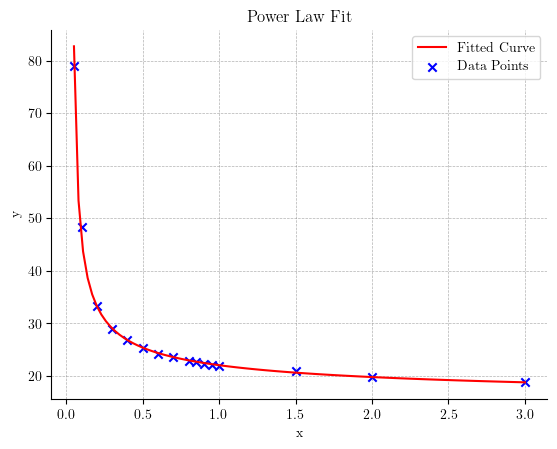

Data points
	Data: 0.0500 -> 78.9853, Pred x->y: 82.7294 (rel error 0.0474), Pred y->x: 0.0520 (rel error 0.0393)
	Data: 0.1000 -> 48.3582, Pred x->y: 46.0420 (rel error -0.0479), Pred y->x: 0.0923 (rel error -0.0767)
	Data: 0.2000 -> 33.3719, Pred x->y: 33.2610 (rel error -0.0033), Pred y->x: 0.1982 (rel error -0.0089)
	Data: 0.3000 -> 28.9958, Pred x->y: 29.0557 (rel error 0.0021), Pred y->x: 0.3021 (rel error 0.0069)
	Data: 0.4000 -> 26.7733, Pred x->y: 26.8160 (rel error 0.0016), Pred y->x: 0.4025 (rel error 0.0062)
	Data: 0.5000 -> 25.3082, Pred x->y: 25.3777 (rel error 0.0027), Pred y->x: 0.5059 (rel error 0.0118)
	Data: 0.6000 -> 24.2598, Pred x->y: 24.3539 (rel error 0.0039), Pred y->x: 0.6108 (rel error 0.0181)
	Data: 0.7000 -> 23.5094, Pred x->y: 23.5776 (rel error 0.0029), Pred y->x: 0.7100 (rel error 0.0144)
	Data: 0.8000 -> 22.8925, Pred x->y: 22.9620 (rel error 0.0030), Pred y->x: 0.8127 (rel error 0.0159)
	Data: 0.8500 -> 22.5923, Pred x->y: 22.6984 (rel error 0.0047), P

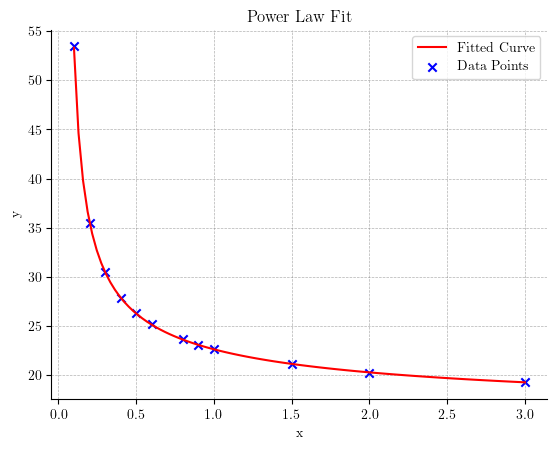

Data points
	Data: 0.1000 -> 53.4501, Pred x->y: 53.2971 (rel error -0.0029), Pred y->x: 0.0996 (rel error -0.0037)
	Data: 0.2000 -> 35.4731, Pred x->y: 35.6190 (rel error 0.0041), Pred y->x: 0.2019 (rel error 0.0095)
	Data: 0.3000 -> 30.4892, Pred x->y: 30.4981 (rel error 0.0003), Pred y->x: 0.3002 (rel error 0.0009)
	Data: 0.4000 -> 27.8551, Pred x->y: 27.8972 (rel error 0.0015), Pred y->x: 0.4021 (rel error 0.0053)
	Data: 0.5000 -> 26.3208, Pred x->y: 26.2723 (rel error -0.0018), Pred y->x: 0.4964 (rel error -0.0072)
	Data: 0.6000 -> 25.1592, Pred x->y: 25.1369 (rel error -0.0009), Pred y->x: 0.5977 (rel error -0.0038)
	Data: 0.8000 -> 23.6628, Pred x->y: 23.6220 (rel error -0.0017), Pred y->x: 0.7932 (rel error -0.0085)
	Data: 0.9000 -> 23.0777, Pred x->y: 23.0820 (rel error 0.0002), Pred y->x: 0.9009 (rel error 0.0010)
	Data: 1.0000 -> 22.6639, Pred x->y: 22.6322 (rel error -0.0014), Pred y->x: 0.9924 (rel error -0.0076)
	Data: 1.5000 -> 21.1168, Pred x->y: 21.1482 (rel error 0.00

In [8]:
from plot_utils import PowerLaw

# Fit power law for baseline p(c)
print("p(c)")
df_fit = df_runs[
    (df_runs.frac_duplicated == 0) & \
    (df_runs.seed == 0) & \
    (df_runs.model_size == "small") & \
     df_runs["dedup_type"].isna() 
]
pc_plaw = PowerLaw((df_fit.train_steps / STANDARD_STEPS), df_fit.ppl) #, reversed=True)
pc_plaw.show()

print()
# Fit power law for duplicated vocab p(w)
print("p(w)")
df_fit = df_runs[
    (df_runs.frac_duplicated == 1) & \
    (df_runs["p_dup"] == 0.5) & \
    (df_runs.seed == 0) & \
    (df_runs.model_size == "small") & \
    ((df_runs["dedup_type"] == "") | df_runs["dedup_type"].isna()) 
]
pw_plaw = PowerLaw((df_fit.train_steps / STANDARD_STEPS), df_fit.ppl) #, reversed=True)
pw_plaw.show()

### Figure 1

/Users/anton/Repositories/fork-languini-kitchen/languini/de_duplication/plot_utils.py:27: RuntimeWarning: invalid value encountered in power
  return -a * x**(-b) + c
/var/folders/hz/b9kbx68n5ms514d0lq55by480000gn/T/ipykernel_73265/101912680.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


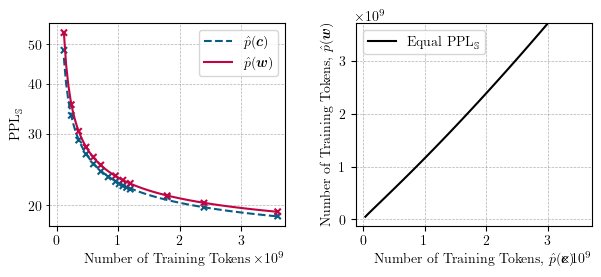

In [9]:
fig, axs = plt.subplots(figsize=(PLOT_WIDTH*2, PLOT_HEIGHT), ncols=2, gridspec_kw={'wspace': 0.3})
ax_both, ax_diff = axs


default_n_tokens = STANDARD_STEPS * 512 * 128

# plot power laws
markersize=20
pc_plaw.plot(ax_both, x_left=0.099, label=PC, c1=COL_C, c2=COL_C, label_datapoints=None, linestyle="--", markersize=markersize, x_factor=default_n_tokens)
pw_plaw.plot(ax_both, label=PW, c1=COL_W, c2=COL_W, label_datapoints=None, linestyle="-", markersize=markersize, x_factor=default_n_tokens)
ax_both.legend()
ax_both.set_xlabel('Number of Training Tokens')
ax_both.set_ylabel(PPLS)
ax_both.spines['right'].set_visible(True)
ax_both.spines['top'].set_visible(True)
ax_both.set_yscale("log")
ax_both.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6, which="both")
import matplotlib.ticker as ticker
ax_both.yaxis.set_minor_formatter(ticker.ScalarFormatter())

# plot p(w) vs p(c)
x_min, x_max = -0.1, 3.1
xvals = np.linspace(x_min, x_max, 100) 
ax_diff.plot(default_n_tokens * xvals, default_n_tokens * pw_plaw.x(pc_plaw.y(xvals)), label="Equal " + PPLS, color="black")
ax_diff.set_ylim(default_n_tokens * x_min, default_n_tokens * x_max)
ax_diff.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
ax_diff.set_xlabel("Number of Training Tokens, " + PC)
ax_diff.set_ylabel("Number of Training Tokens, " + PW)
ax_diff.legend()

for ax in axs:
    ax.set_xlim(default_n_tokens * x_min, default_n_tokens * x_max)

save_plot("bl_dup_scaling.png")

## Frac. of vocab duplicated
### Figure 2

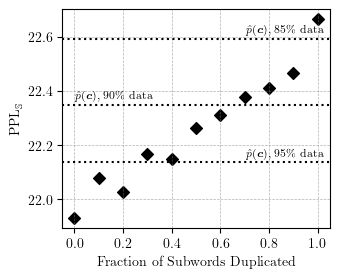

In [10]:
df_plot = df_runs[
    (df_runs.model_size == "small") & \
    df_runs["dedup_type"].isna() & \
    df_runs["p_dup"].isin([float("nan"), 0.5])  & \
    (df_runs.train_steps == STANDARD_STEPS) & \
    (df_runs.seed == 0) 
].copy()

fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT * 1.1))

ax.scatter(df_plot.frac_duplicated, df_plot.ppl, label=None, marker="D", color="k")
ax.set_xlabel("Fraction of Subwords Duplicated")
ax.set_ylabel("$\\mathrm{PPL}_\\mathbb{S}$")
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)

# draw horizontal lines showing performance of 85%, 90%, 95% training
yshift = 0.033
for percent_data, xpos in zip([85, 90, 95], [0.7, 0.0, 0.7]):
    df_relevant = df_runs[
        (df_runs.train_steps == int(percent_data/100 * STANDARD_STEPS)) & \
        (df_runs.model_size == "small") & \
        ((df_runs["dedup_type"] == "") | df_runs["dedup_type"].isna()) & \
        (df_runs.frac_duplicated == 0) & \
        (df_runs.seed == 0) 
    ]
    assert len(df_relevant) == 1
    ppls = df_relevant.ppl.values[0]
    label = "$\hat{p}(\\boldsymbol{c})$, " + str(percent_data) + "\\% data"
    ax.axhline(ppls, color="k", linestyle="dotted")
    ax.text(xpos, ppls + yshift, label, fontsize=8, verticalalignment='center')


# write label at the end of the line
save_plot("dup_frac_dup_ppl.png")

## Embedding similarity

In [11]:
from languini.common_lib.experiment_utils import load_wandb_file
import torch.nn.functional as F
import pickle


def get_subword_embeddings(run_path, device="cpu", output_embeddings=False):
    checkpoint = torch.load(load_wandb_file(run_path, "checkpoints/model.pt", cache_dir=CACHE_DIR), map_location=device)
    if output_embeddings:
        return checkpoint["model_state_dict"]["module._orig_mod.linear.weight"]
    else:
        return checkpoint["model_state_dict"]["module._orig_mod.input_embedding.weight"]


def compute_dup_cosine_similarities(emb):
    """
    Assumes frac_duplicated = 1.0 and vocab_size = 16384
    """
    vocab_size = 16384
    # sim = F.cosine_similarity(emb.unsqueeze(1), emb.unsqueeze(0), dim=-1) crashes kernel due to OOM
    emb_normed = emb / emb.norm(dim=1, keepdim=True)
    sim = emb_normed @ emb_normed.T
    result = {
        "any": float(sim.nanmean()),
        "dups": float(sim.diag(vocab_size).nanmean()),
        "dups_all": sim.diag(vocab_size).cpu().numpy(),
    }
    return result


def compute_gpt_dup_cosine_similarities(run_path):
    # load from cache if available
    run_id = run_path.split("/")[-1]
    cache_path = os.path.join(CACHE_DIR, run_id, "cossim.pkl")
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    emb_in = get_subword_embeddings(run_path)
    result = {k + "_in": v for k, v in compute_dup_cosine_similarities(emb_in).items()}
    emb_out = get_subword_embeddings(run_path, output_embeddings=True)
    result.update({k + "_out": v for k, v in compute_dup_cosine_similarities(emb_out).items()})

    # store in cache
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)

    return result

In [12]:
df_sim = df_runs[
    (df_runs.model_size == "small") & \
    df_runs["dedup_type"].isna() & \
    (df_runs.train_steps == STANDARD_STEPS) & \
    (df_runs.seed == 0) & \
    (df_runs.frac_duplicated == 1.0)
].copy()
# create columns with type object to store arrays
df_sim["sim_dups_all_in"], df_sim["sim_dups_all_out"] = None, None

for run_id, row in tqdm(df_sim.iterrows(), total=len(df_sim)):
    run_path = run_id2path(run_id)
    for k, v in compute_gpt_dup_cosine_similarities(run_path).items():
        df_sim.at[run_id, f"sim_{k}"] = v

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# compute token frequencies in training data
from languini.dataset_lib.languini_books import LanguiniDatasetIterator
from languini.de_duplication.mappings import IdentityMapping

cache_file = os.path.join(CACHE_DIR, "train_frequencies.npy")

if os.path.exists(cache_file):
    # load from cache
    train_frequencies = np.load(cache_file)
else:
    # compute frequencies
    END_OF_DOC_TOKEN = 2
    seq_len = 512
    train_batch_size = 128
    device = "cpu"
    full_data_path = os.path.join(ROOT_DIR, "data/books", "books_16384")

    train_ds = LanguiniDatasetIterator(
        data_path=full_data_path,
        split='train',
        repeat=True,
        global_batch_size=train_batch_size,
        batch_idxs=list(range(train_batch_size)),
        micro_batches=1,
        sequence_length=seq_len,
        device=device,
        end_of_doc_token=END_OF_DOC_TOKEN,
        vocab_mapping=IdentityMapping(ORIGINAL_VOCAB_SIZE),
    )

    train_frequencies = torch.zeros(ORIGINAL_VOCAB_SIZE, device=device)
    for step in tqdm(range(STANDARD_STEPS)):
        total_batch_x, total_batch_y, _, _ = next(train_ds)
        for batch_y in total_batch_y:
            train_frequencies += torch.bincount(batch_y.reshape(-1), minlength=ORIGINAL_VOCAB_SIZE)
    train_frequencies = train_frequencies.numpy()

    # store in cache
    np.save(cache_file, train_frequencies)


### Figure 3

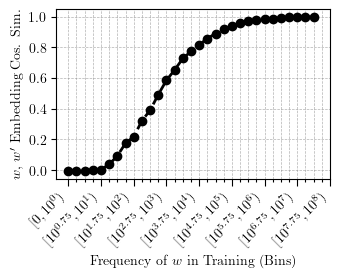

In [14]:
from plot_utils import BinPlot

occ_mask = train_frequencies > 0
bin_plot = BinPlot(x_all=train_frequencies[occ_mask])

# plot cosine similarities for p(w' | c) = 0.5
row = df_sim[df_sim.p_dup == 0.5].iloc[0]

fig, ax = plt.subplots(1, 1, figsize=(PLOT_WIDTH, 1.1 * PLOT_HEIGHT))
x, y = train_frequencies[occ_mask], row.sim_dups_all_in[occ_mask]
x = x * row.p_dup
ax.plot(*bin_plot.to_bins(x, y), color="k", linewidth=2, linestyle="--", marker="o")

ax.set_ylabel("$w$, $w'$ Embedding Cos. Sim.")
ax.set_xlabel("Frequency of $w$ in Training (Bins)")
ax.set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")
bin_plot.adjust_tick_lengths(ax)
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
save_plot("dup_cossim_by_freq")

### Figure 7 (Appendix)

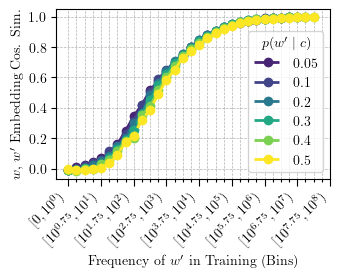

In [15]:
from plot_utils import BinPlot
from matplotlib import colors as mcolors

occ_mask = train_frequencies > 0
bin_plot = BinPlot(x_all=train_frequencies[occ_mask])

# normalize p_dup for colormap
norm = mcolors.Normalize(vmin=0, vmax=0.5)
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 1, figsize=(PLOT_WIDTH, 1.1 * PLOT_HEIGHT))
for i, row in df_sim.sort_values(by="p_dup").iterrows():
    x, y = train_frequencies[occ_mask], row.sim_dups_all_in[occ_mask]
    x = x * row.p_dup
    ax.plot(*bin_plot.to_bins(x, y), color=cmap(norm(row.p_dup)), linewidth=2, linestyle="--", marker="o", label="$" + str(row.p_dup) + "$")

ax.set_ylabel("$w$, $w'$ Embedding Cos. Sim.")
ax.set_xlabel("Frequency of $w'$ in Training (Bins)")
ax.set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")
bin_plot.adjust_tick_lengths(ax)
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
ax.legend()
ax.legend(title=f"$p(w' \\mid c)$")
save_plot("dup_cossim_by_freq_pdup")

### Figure 6 (Appendix)

In [16]:
# load word2vec results
def compute_w2v_dup_cosine_similarities(w2v_dir):
    # load from cache if available
    w2v_id = "w2v_" + w2v_dir.split("/")[-1]
    cache_path = os.path.join(CACHE_DIR, w2v_id, "cossim.pkl")
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    emb_in = torch.load(os.path.join(w2v_dir, "input_embeddings.pt"))
    result = {k + "_in": v for k, v in compute_dup_cosine_similarities(emb_in).items()}
    emb_out = torch.load(os.path.join(w2v_dir, "output_embeddings.pt"))
    result.update({k + "_out": v for k, v in compute_dup_cosine_similarities(emb_out).items()})

    # store in cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)

    return result


# create columns with type object to store arrays
df_sim["w2v_sim_dups_all_in"], df_sim["w2v_sim_dups_all_out"] = None, None
for run_id, row in tqdm(df_sim.iterrows(), total=len(df_sim)):
    run_path = run_id2path(run_id)
    # find corresponding word2vec run
    w2v_dir = f"{W2V_RESULTS_DIR}/{row.frac_duplicated}_{row.p_dup}_0"
    for k, v in compute_w2v_dup_cosine_similarities(w2v_dir).items():
        df_sim.at[run_id, f"w2v_sim_{k}"] = v

  0%|          | 0/6 [00:00<?, ?it/s]

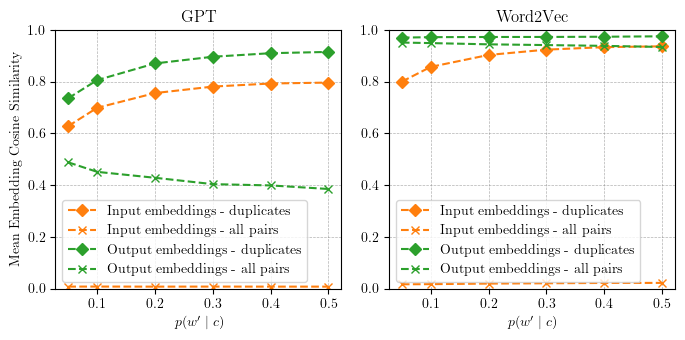

In [17]:
fig, axs = plt.subplots(figsize=(2 * PLOT_WIDTH, PLOT_WIDTH), ncols=2)
cmap = plt.get_cmap("tab10")

linestyle = "--"
df_sim = df_sim.sort_values(by="p_dup")

for ax, title, prefix in zip(axs, ["GPT", "Word2Vec"], ["", "w2v_"]):
    for io_title, io_id, io_color in zip(["Input", "Output"], ["in", "out"], [cmap(1), cmap(2)]):
        for dup_title, dup_id, dup_marker in zip(["duplicates", "all pairs"], ["dups", "any"], ["D", "x"]):
            key = f"{prefix}sim_{dup_id}_{io_id}"
            ax.plot(df_sim.p_dup, df_sim[key], label=f"{io_title} embeddings - {dup_title}", marker=dup_marker, color=io_color, linestyle=linestyle)

    ax.set_title(title)
    ax.set_xlabel(f"$p(w' \\mid c)$")
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)

axs[0].set_ylabel("Mean Embedding Cosine Similarity")

save_plot("dup_pdup_cossim.png")

## GLUE
### Table 3

In [18]:
import json

# use baseline and token-level 50/50 
# TODO should use 3jvt5rjo (baseline seed 0) instead of 8w47vfai (baseline seed 1) baseline seed 1. (but GLUE not ran yet)
df_glue = df_runs[df_runs.index.isin(["8w47vfai",  "x9xu9gah"])].copy()

# read results from GLUE finetuning
for dirname in os.listdir(FINETUNE_RESULTS_DIR):
    runid = dirname.split("_")[2]
    freeze = "_freeze_embeddings" if "freeze_embeddings" in dirname else ""

    # read accuracies of all tasks in L1 (w) and L2 (w')
    l1_accs, l2_accs = [], []
    run_dir = os.path.join(FINETUNE_RESULTS_DIR, dirname)
    for task in os.listdir(run_dir):
        with open(os.path.join(run_dir, task, "eval_L1_results.json"), "r") as f:
            l1_accs.append(float(json.loads(f.read())["eval_accuracy"]))
        l2_res_path = os.path.join(run_dir, task, "eval_L2_results.json")
        if os.path.exists(l2_res_path):
            with open(l2_res_path, "r") as f:
                l2_accs.append(float(json.loads(f.read())["eval_accuracy"]))
        else:
            # models that aren't trained with duplication don't have L2 results
            l2_accs.append(float("nan"))

    df_glue.at[runid, "GLUE_w" + freeze] = np.mean(l1_accs)
    df_glue.at[runid, "GLUE_w'" + freeze] = np.mean(l2_accs)

colnames = ["frac_duplicated", "ppl", "GLUE_w", "GLUE_w'", "GLUE_w_freeze_embeddings", "GLUE_w'_freeze_embeddings"]
for col_name in colnames:
    df_glue[col_name] = df_glue[col_name].apply(lambda x: round(x, 2))
display(df_glue[colnames])

,frac_duplicated,ppl,GLUE_w,GLUE_w',GLUE_w_freeze_embeddings,GLUE_w'_freeze_embeddings
run_id,,,,,,
x9xu9gah,1.0,22.66,0.73,0.7,0.71,0.71
8w47vfai,0.0,21.99,0.72,NaN,0.71,NaN


## Causal Effect of Duplication

In [19]:
# identify relevant runs

print("Baseline")
display(df_runs[
    (df_runs.frac_duplicated == 0) & \
    (df_runs.seed == 0) & \
    (df_runs.model_size == "small") & \
    df_runs.dedup_type.isna() &\
    (df_runs.train_steps == STANDARD_STEPS)
])
print("Dup 50%")
display(df_runs[
    (df_runs.frac_duplicated == 0.5) & \
    (df_runs.p_dup == 0.5) & \
    (df_runs.seed == 0) & \
    (df_runs.model_size == "small") & \
    (df_runs.dedup_type.isin(["", float("nan")])) & \
    (df_runs.train_steps == STANDARD_STEPS)
])

Baseline


,model_size,train_steps,seed,frac_duplicated,p_dup,dedup_type,embed_noncanonical,ppl,ppl_dedup_all,ppl_dedup_lower,ppl_dedup_plural,ppl_dedup_whitespace
run_id,,,,,,,,,,,,
3jvt5rjo,small,18265,0,0.0,NaN,NaN,False,21.930433,20.989335,21.506129,21.564758,21.798444


Dup 50%


,model_size,train_steps,seed,frac_duplicated,p_dup,dedup_type,embed_noncanonical,ppl,ppl_dedup_all,ppl_dedup_lower,ppl_dedup_plural,ppl_dedup_whitespace
run_id,,,,,,,,,,,,
dpjniac4,small,18265,0,0.5,0.5,NaN,False,22.261498,NaN,NaN,NaN,NaN


In [20]:
# load token-wise test results

run_id_dup = "dpjniac4"
run_id_bl = "3jvt5rjo"

test_dir = "test_128/" # test results with last_n=128 and no deduplication

run_path_dup = run_id2path(run_id_dup)
y_dup = np.load(load_wandb_file(run_path_dup, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
surprisal_dup = np.load(load_wandb_file(run_path_dup, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))

run_path_bl = run_id2path(run_id_bl)
y_bl = np.load(load_wandb_file(run_path_bl, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
surprisal_bl = np.load(load_wandb_file(run_path_bl, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))

In [21]:
# compute deltas
assert np.equal(y_dup % ORIGINAL_VOCAB_SIZE, y_bl).all(), "didn't evaluate on same data"
delta_surprisals = surprisal_dup - surprisal_bl

# filter out padding and invalid losses due to sliding window
is_relevant = (y_bl != 0) & (~np.isnan(surprisal_bl))

# identify which tokens are duplicated (whether they appear duplicated or not)
from languini.de_duplication.mappings import DuplicationMapping
mapping = DuplicationMapping(ORIGINAL_VOCAB_SIZE, frac_duplicated=0.5, p_duplicate=0.5, seed=0)
subword_is_duplicated = mapping.is_duplicated.numpy()
y_token_is_duplicated = subword_is_duplicated[y_bl]

### Table 4: Delta surprisal under duplication

In [22]:
print(f"All: {np.mean(delta_surprisals[is_relevant]):.5f}")
print(f"Duplicated: {np.mean(delta_surprisals[is_relevant & y_token_is_duplicated]):.5f}")
print(f"Not Duplicated: {np.mean(delta_surprisals[is_relevant & (~y_token_is_duplicated)]):.5f}")

All: 0.01499
Duplicated: 0.01841
Not Duplicated: 0.01171


### Fig 4: Delta surprisal by frequency

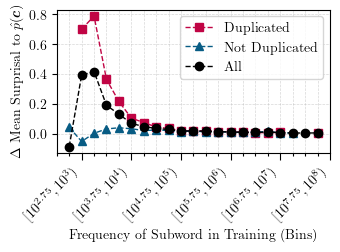

In [23]:
# surprisal per subword
test_frequencies = np.bincount(y_bl[is_relevant], minlength=ORIGINAL_VOCAB_SIZE)
mean_delta_surprisals = np.bincount(y_bl[is_relevant], weights=delta_surprisals[is_relevant], minlength=ORIGINAL_VOCAB_SIZE) / test_frequencies.clip(min=1)

occ_mask = (test_frequencies >= 10) & (train_frequencies > 0)
bin_plot = BinPlot(x_all=train_frequencies[occ_mask])
fig, ax = plt.subplots(1, 1, figsize=(1 * PLOT_WIDTH, PLOT_HEIGHT))

mask_to_label = [
    (subword_is_duplicated, "Duplicated", COL_W, "s"),
    (~subword_is_duplicated, "Not Duplicated", COL_C, "^"),
    (np.ones_like(subword_is_duplicated), "All", "black", "o")
]
for i, (mask, label, color, marker) in enumerate(mask_to_label):
    ax.plot(
        *bin_plot.to_bins(train_frequencies[occ_mask & mask], mean_delta_surprisals[occ_mask & mask], min_count=3),
        label=label, color=color, linewidth=1, linestyle="--", marker=marker
    )

ax.set_ylabel("$\Delta$ Mean Surprisal to " + PC)
ax.set_xlabel("Frequency of Subword in Training (Bins)")
ax.set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")
bin_plot.adjust_tick_lengths(ax)
ax.legend()
ax.grid(linewidth=0.5, linestyle="--", alpha=0.5)
ax.set_xlim([10, ax.get_xlim()[1]]) # restrict to domain where we have data
save_plot("dup_output_surprisal_freq")

### Fig 5: Duplicates in context 

In [24]:
# Determine number of duplicates in context at each position
x_bl = np.load(load_wandb_file(run_path_bl, test_dir + "x.npy", cache_dir=CACHE_DIR)).astype(int)
x_dup = np.load(load_wandb_file(run_path_dup, test_dir + "x.npy", cache_dir=CACHE_DIR)).astype(int)
assert np.equal(x_dup % ORIGINAL_VOCAB_SIZE, x_bl).all(), "didn't evaluate on same data"
x_token_is_duplicated = subword_is_duplicated[x_bl]
n_dups_full_context = np.cumsum(x_token_is_duplicated, axis=1)
n_dups_16_context = np.concatenate([n_dups_full_context[:, :16], n_dups_full_context[:, 16:] - n_dups_full_context[:, :-16]], axis=1)

# normalize by size of considered context
frac_dups_full_context = n_dups_full_context / np.arange(start=1, stop=513).reshape(1, -1)
frac_dups_16_context = n_dups_16_context / np.arange(start=1, stop=513).clip(max=16).reshape(1, -1)

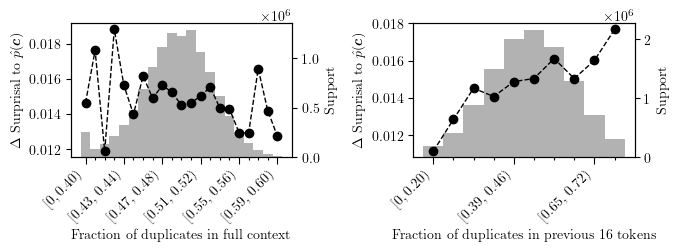

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(2 * PLOT_WIDTH, PLOT_HEIGHT))

# choose bucket domains that cover most of the probability mass (-> no almost empty buckets, they will be included in the first/last buckets here)
bin_plots = [
    BinPlot(x_all=[0.4, 0.6], binsizing="steps_0.01"), # for full context
    BinPlot(x_all=[0.25, 0.75], binsizing="steps_0.065"), # for 16 context
]
for ax, bin_plot, frac_dups in zip(axs, bin_plots, [frac_dups_full_context, frac_dups_16_context]):
    # create axis with support in the background
    ax_support = ax.twinx()
    ax.set_zorder(ax_support.get_zorder() + 1)
    ax.patch.set_visible(False)

    x, y, support = bin_plot.to_bins(frac_dups[is_relevant], delta_surprisals[is_relevant], return_support=True)
    ax.plot(x, y, color="k", linewidth=1, linestyle="--", marker="o", zorder=0)
    ax_support.bar(x, support, color="k", alpha=0.3, zorder=1, width=1)

    # labels
    ax.set_ylabel("$\Delta$ Surprisal to " + PC)
    ax_support.set_ylabel("Support")# (bars stacked)")
    tick_every = 4
    xticks, xlabels = bin_plot.get_ticks_labels()
    ax.set_xticks(xticks, labels=[l if i % tick_every == 0 else "" for i, l in enumerate(xlabels)], rotation=45, ha="right")
    bin_plot.adjust_tick_lengths(ax)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

axs[0].set_xlabel("Fraction of duplicates in full context")
axs[1].set_xlabel("Fraction of duplicates in previous 16 tokens")

save_plot("dup_input_surprisal")

# Near Duplicates

## Performance
### Table 5

In [26]:
df_near_dup = df_runs.copy()
df_near_dup["dedup_type"] = df_near_dup["dedup_type"].fillna("-no dedup-")
df_near_dup = df_near_dup[
    (df_near_dup.frac_duplicated == 0) & \
    (df_near_dup.model_size == "small") & \
    (~df_near_dup.dedup_type.str.contains("50%")) & \
    (df_near_dup.train_steps == STANDARD_STEPS)
]

df_near_dup = df_near_dup.groupby(["dedup_type", "embed_noncanonical"])[
    [c for c in df_near_dup.columns if "ppl_" in c]
    ].agg(
        ["mean", "std"]
    )
display(df_near_dup)

ppl_dedup_all           ppl_dedup_lower  \
                                       mean       std            mean   
dedup_type embed_noncanonical                                           
-no dedup- False                  20.987085  0.108317       21.504123   
all        False                  22.083820  0.090365             NaN   
lower      False                        NaN       NaN       21.865913   
           True                         NaN       NaN       21.447217   
plural     False                        NaN       NaN             NaN   
           True                         NaN       NaN             NaN   
whitespace False                        NaN       NaN             NaN   
           True                         NaN       NaN             NaN   

                                        ppl_dedup_plural            \
                                    std             mean       std   
dedup_type embed_noncanonical                                        
-no dedup- False               0.112176        21.561245  0.113172   
all        False                    NaN              NaN       NaN   
lower      False               0.147221              NaN       NaN   
           True                0.116532              NaN       NaN   
plural     False                    NaN        21.816530  0.109840   
           True                     NaN        21.592624  0.136295   
whitespace False                    NaN              NaN       NaN   
           True                     NaN              NaN       NaN   

                              ppl_dedup_whitespace            
                                              mean       std  
dedup_type embed_noncanonical                                 
-no dedup- False                         21.795146  0.114132  
all        False                               NaN       NaN  
lower      False                               NaN       NaN  
           True                                NaN       NaN  
plural     False                               NaN       NaN  
           True                                NaN       NaN  
whitespace False                         22.144235  0.160197  
           True                          21.919896  0.166716

## Embedding Similarity

In [27]:
import sentencepiece as spm
from languini.de_duplication.mappings import DeduplicationMapping

embeddings_bl = get_subword_embeddings(run_path_bl)
emb_normed = embeddings_bl / embeddings_bl.norm(dim=1, keepdim=True)
sims_bl = emb_normed @ emb_normed.T

sp = spm.SentencePieceProcessor()
assert sp.Load(os.path.join(ROOT_DIR, "languini/vocabs/spm_models/books_16384.model"))

print("Mean similarities of near duplicates' input embeddings")
for dedup_type in ["whitespace", "lower", "plural"]:
    mapping = DeduplicationMapping(sp, dedup_type)
    ids = torch.arange(ORIGINAL_VOCAB_SIZE)
    pairs = [(i, mapped_i) for i, mapped_i in zip(ids, mapping(ids)) if i != mapped_i]
    print(f"{dedup_type}: {float(sims_bl[list(zip(*pairs))].mean()):.2f}")

Mean similarities of near duplicates' input embeddings
whitespace: 0.43
lower: 0.42
plural: 0.44


## Causal Effect of Deduplication

In [28]:
df_half_near_dup = df_runs[
    (df_runs.frac_duplicated == 0) & \
    (df_runs.model_size == "small") & \
    (df_runs.dedup_type.str.contains("50%")) & \
    (df_runs.train_steps == STANDARD_STEPS)
].copy()
display(df_half_near_dup)

,model_size,train_steps,seed,frac_duplicated,p_dup,dedup_type,embed_noncanonical,ppl,ppl_dedup_all,ppl_dedup_lower,ppl_dedup_plural,ppl_dedup_whitespace
run_id,,,,,,,,,,,,
1w1zplf3,small,18265,0,0.0,NaN,lower_50%,False,NaN,NaN,21.677875,NaN,NaN
rv05e06w,small,18265,0,0.0,NaN,plural_50%,False,NaN,NaN,NaN,21.711509,NaN
3wow9x6k,small,18265,0,0.0,NaN,whitespace_50%,False,NaN,NaN,NaN,NaN,22.071076


In [29]:
from languini.de_duplication.mappings import HalfDeduplicationMapping, DeduplicationMapping


# track which subwords are fully deduplicated (treatment group) or fully nondeduplicated (control group)
filters = {}

for dedup_type in ["whitespace", "lower", "plural"]:
    # ids and id->mapped_id
    ids = np.arange(ORIGINAL_VOCAB_SIZE)
    ids_mapped = DeduplicationMapping(sp, dedup_type=dedup_type)(torch.arange(ORIGINAL_VOCAB_SIZE)).numpy()
    ids_half_mapped = HalfDeduplicationMapping(sp, dedup_type=dedup_type)(torch.arange(ORIGINAL_VOCAB_SIZE)).numpy()
    is_remappable = ids != ids_mapped
    is_remapped = ids != ids_half_mapped
    is_mappable_to = np.bincount(ids_mapped, minlength=ORIGINAL_VOCAB_SIZE) > 1
    has_neardups = is_remappable | is_mappable_to

    # find fully deduplicated subwords, i.e., all their near-duplicates are remapped
    is_fully_mapped_to = (np.bincount(ids_half_mapped, minlength=ORIGINAL_VOCAB_SIZE) == np.bincount(ids_mapped, minlength=ORIGINAL_VOCAB_SIZE)) & is_mappable_to
    is_fully_deduplicated = is_fully_mapped_to[ids_half_mapped]

    # find fully nondeduplicated subwords, i.e., none of their near-duplicates are remapped
    is_mapped_to = np.bincount(ids_half_mapped, minlength=ORIGINAL_VOCAB_SIZE) > 1
    is_partially_deduplicated = is_mapped_to[ids_mapped]
    is_fully_nondeduplicated = has_neardups & ~is_partially_deduplicated

    filters[dedup_type] = {
        "dedup": is_fully_deduplicated,
        "nondedup": is_fully_nondeduplicated,
    }

### Table 6: Delta suprisal under deduplication

In [30]:
for run_id_dup, row in df_half_near_dup.iterrows():
    dedup_type = row["dedup_type"].split("_")[0]

    test_dir = f"test_128_{dedup_type}/" # test results with last_n=128 and the corresponding deduplication
    run_path_dup = run_id2path(run_id_dup)
    y_dup = np.load(load_wandb_file(run_path_dup, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
    surprisal_dup = np.load(load_wandb_file(run_path_dup, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))

    run_path_bl = run_id2path(run_id_bl)
    y_bl = np.load(load_wandb_file(run_path_bl, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
    surprisal_bl = np.load(load_wandb_file(run_path_bl, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))

    # compute deltas
    delta_surprisals = surprisal_dup - surprisal_bl

    # filter out padding and invalid losses due to sliding window
    is_relevant = (y_bl != 0) & (~np.isnan(surprisal_bl))
    y_token_is_dedup = filters[dedup_type]["dedup"][y_bl]
    y_token_is_nondedup = filters[dedup_type]["nondedup"][y_bl]

    print("Deduplication type:", dedup_type)
    print(f"\tAll: {np.mean(delta_surprisals[is_relevant]):.5f}")
    print(f"\tDuplicated: {np.mean(delta_surprisals[is_relevant & y_token_is_dedup]):.5f}")
    print(f"\tNot Duplicated: {np.mean(delta_surprisals[is_relevant & y_token_is_nondedup]):.5f}")
    print()

Deduplication type: lower
	All: 0.00797
	Duplicated: 0.00921
	Not Duplicated: 0.00765

Deduplication type: plural
	All: 0.00677
	Duplicated: 0.01009
	Not Duplicated: 0.00909

Deduplication type: whitespace
	All: 0.01243
	Duplicated: 0.01360
	Not Duplicated: 0.00969



### Figure 8: Deduplicated in context 

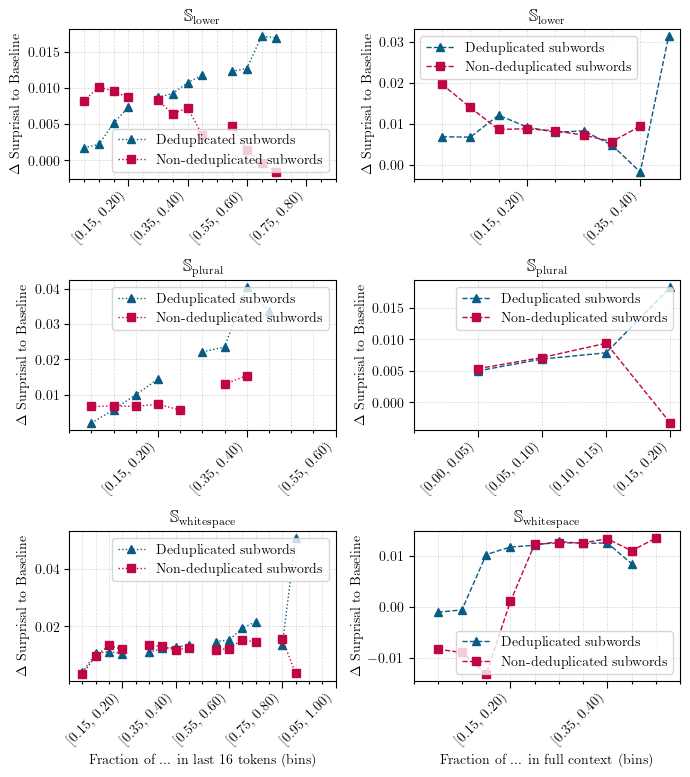

In [31]:
min_bin_count=1000 # we are dealing with individual surprisals, not averages over subwords as above => reduce noise

fig, axs = plt.subplots(len(df_half_near_dup), 2, figsize=(2 * PLOT_WIDTH, PLOT_HEIGHT * len(df_half_near_dup)))
#axs = axs.reshape(len(df_half_near_dup), 2)

for i, (run_id_dup, row) in enumerate(df_half_near_dup.iterrows()):
    dedup_type = row["dedup_type"].split("_")[0]
    
    # load token-wise test results
    test_dir = f"test_128_{dedup_type}/" # test results with last_n=128 and the corresponding deduplication
    run_path_dup = run_id2path(run_id_dup)
    x_dup = np.load(load_wandb_file(run_path_dup, test_dir + "x.npy", cache_dir=CACHE_DIR)).astype(int)
    y_dup = np.load(load_wandb_file(run_path_dup, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
    surprisal_dup = np.load(load_wandb_file(run_path_dup, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))
    run_path_bl = run_id2path(run_id_bl)
    x_bl = np.load(load_wandb_file(run_path_bl, test_dir + "x.npy", cache_dir=CACHE_DIR)).astype(int)
    y_bl = np.load(load_wandb_file(run_path_bl, test_dir + "y.npy", cache_dir=CACHE_DIR)).astype(int)
    surprisal_bl = np.load(load_wandb_file(run_path_bl, test_dir + "surprisals.npy", cache_dir=CACHE_DIR))

    # compute deltas
    delta_surprisals = surprisal_dup - surprisal_bl
    # filter out padding and invalid losses due to sliding window
    is_relevant = (y_bl != 0) & (~np.isnan(surprisal_bl))



    for filter_type, filter_label, color, marker in [("dedup", "Deduplicated", COL_C, "^"), ("nondedup", "Non-deduplicated", COL_W, "s")]:
        x_token_is_special = filters[dedup_type][filter_type][y_bl]
        n_special_full_context = np.cumsum(x_token_is_special, axis=1)
        n_special_16_context = np.concatenate([n_special_full_context[:, :16], n_special_full_context[:, 16:] - n_special_full_context[:, :-16]], axis=1)

        # normalize by size of considered context
        frac_special_full_context = n_special_full_context / np.arange(start=1, stop=513).reshape(1, -1)
        frac_special_16_context = n_special_16_context / np.arange(start=1, stop=513).clip(max=16).reshape(1, -1)

        bin_plot = BinPlot(frac_special_16_context[is_relevant], binsizing="steps_0.05")
        axs[i, 0].plot(*bin_plot.to_bins(frac_special_16_context[is_relevant], delta_surprisals[is_relevant], min_count=min_bin_count), label=f"{filter_label} subwords", color=color, linewidth=1, linestyle="dotted", marker=marker)
        axs[i, 0].set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")

        bin_plot = BinPlot(frac_special_full_context[is_relevant], binsizing="steps_0.05")
        axs[i, 1].plot(*bin_plot.to_bins(frac_special_full_context[is_relevant], delta_surprisals[is_relevant], min_count=min_bin_count), label=f"{filter_label} subwords", color=color, linewidth=1, linestyle="--", marker=marker)
        axs[i, 1].set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")
            
        for ax in axs[i]:
            ax.set_ylabel("$\Delta$ Surprisal to Baseline")
            ax.legend()
            ax.grid(linewidth=0.5, linestyle="--", alpha=0.5)
            # adjust xticks
            xlabels = ax.get_xticklabels()
            if len(xlabels) > 5:
                xlabels = ["" if i % 4 != 0 else l.get_text() for i, l in enumerate(xlabels)]
                ax.set_xticklabels(xlabels)
            bin_plot.adjust_tick_lengths(ax)
            
        axs[i, 0].set_title("$\\mathbb{S}_\\text{" + dedup_type + "}$")
        axs[i, 1].set_title("$\\mathbb{S}_\\text{" + dedup_type + "}$")

# x labels only on bottom row
axs[2, 0].set_xlabel(f"Fraction of ... in last 16 tokens (bins)")
axs[2, 1].set_xlabel(f"Fraction of ... in full context (bins)")

# set y margin between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)

save_plot("dedup_input_causal_surprisal")